In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


Importing the Libraries and frameworks

In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
import PIL
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
image_paths = Path("/content/drive/MyDrive/Medical_Dataset")
train_dir = Path("/content/drive/MyDrive/Medical_Dataset/train") #using Path funtion to get paths from drive in PosixPath format
test_dir = Path("/content/drive/MyDrive/Medical_Dataset/test")

Importing images to Visualize

In [6]:
import random
from PIL import Image

random.seed(42)

#creating a list of images
image_path_list = list(image_paths.glob("*/*/*.jpg"))

path of the image is: /content/drive/MyDrive/Medical_Dataset/train/Nail Fungus and Cracked Nails/img (231).jpg
class of the image is: Nail Fungus and Cracked Nails


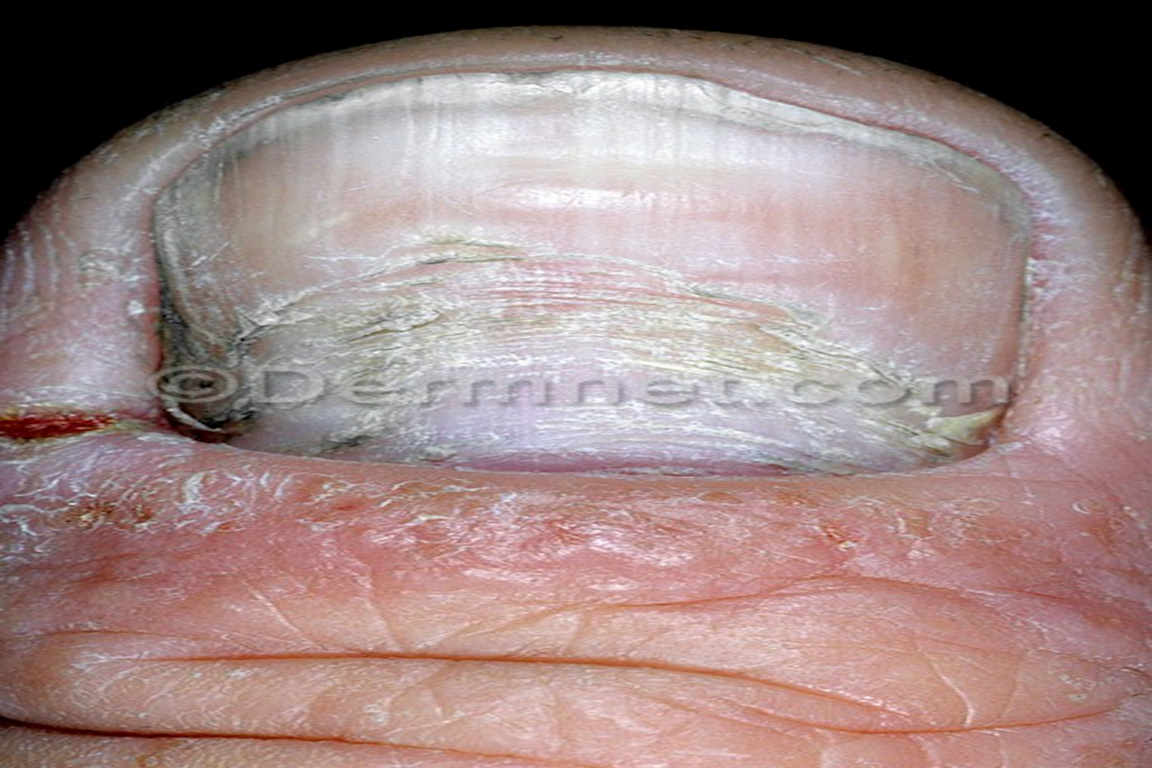

In [7]:
#picking a random image from the list and then printing it out
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"path of the image is: {random_image_path}")
print(f"class of the image is: {image_class}")
img

Text(0.5, 1.0, 'Image class: Nail Fungus and Cracked Nails, Image shape: (768, 1152, 4)')

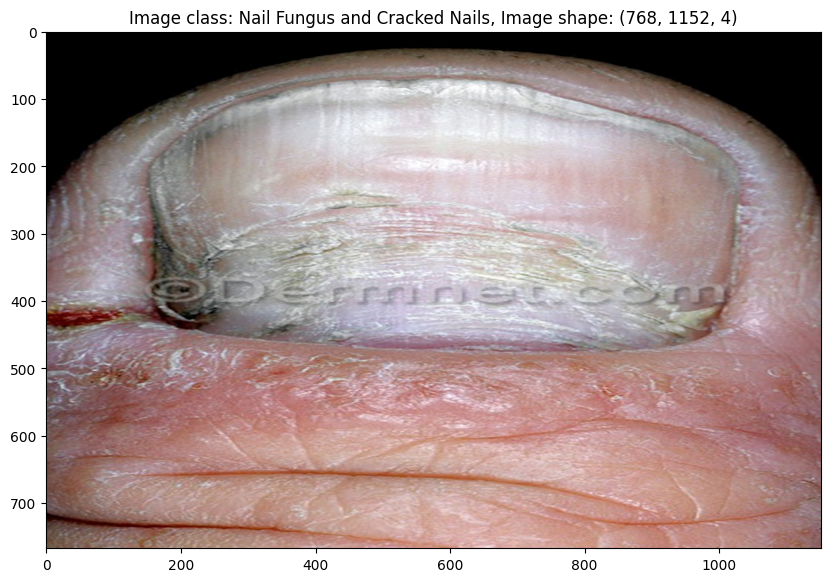

In [8]:
#Converting the image into an array
img_as_array = np.asarray(img)

#plotting the image which is converted into an array
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}, Image shape: {img_as_array.shape}")

In [9]:
img_as_array #this is the image which is converted into an array

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[112,  95,  81, 255],
        [106,  90,  74, 255],
        [ 99,  83,  66, 255],
        ...,
        [146, 101, 100, 255],
        [146, 102, 101, 255],
        [146, 102, 101, 255]],

       [[104,  88,  75, 255],
        [105,  88,  75, 255],
        [106,  89,  76, 255],
        ...,
        [146, 101,  99, 255],
        [147, 101, 101, 255],
        [147, 101, 101, 255]],

       [[105

Converting the data available into datasets

as all the images are of different sizes, they have to be converted into same size for the model to work perfectly and accurately, so transforms function is also needed

In [10]:
from torchvision import datasets, transforms

transform function will have to resize the images to one size. To increase randomness, 50% of the images could be flipped from the horizontal. Again, the images must be converted to a tensor format

Since the image has as an extra channel in the pipline, it will create problem with training the model later on
so, this 4 (1 extra channel, RGBA format)  must be transformed to 3 (RGB channel)

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [12]:
print(f"image as tensor\n: {data_transform(img)}")
print(f"shape of the image tensor: {data_transform(img).shape}")

image as tensor
: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5373, 0.5451, 0.5490,  ..., 0.4431, 0.4314, 0.4196],
         [0.5412, 0.5490, 0.5608,  ..., 0.4431, 0.4392, 0.4314],
         [0.5608, 0.5529, 0.5373,  ..., 0.4549, 0.4353, 0.4196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3725, 0.3843, 0.3922,  ..., 0.3412, 0.3255, 0.3176],
         [0.3686, 0.3843, 0.4000,  ..., 0.3529, 0.3529, 0.3529],
         [0.3843, 0.3882, 0.3804,  ..., 0.3725, 0.3686, 0.3569]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 

A function to random pick n images from the image_path randomly, transforms them (by resizing and into tensor) and then plotting the transformed images side by side with the original images

In [13]:
def plot_transformed_images(image_paths, transform, n, seed):
  random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n) # k stands for how many images in the samle is to be taken

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original Size: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0) #changing colour from 1st position to last
      ax[1].imshow(f)
      ax[1].set_title(f"Transformed shape: {transformed_image.shape}")
      ax[1].axis(False)

      #adding the class name on top
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

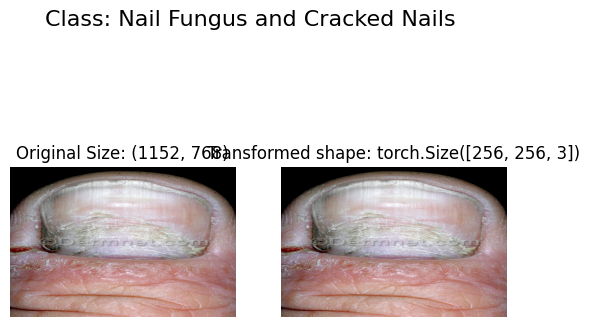

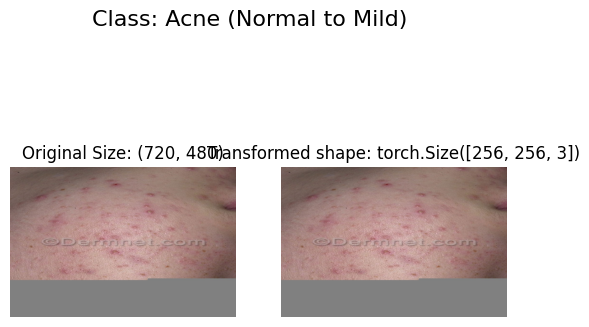

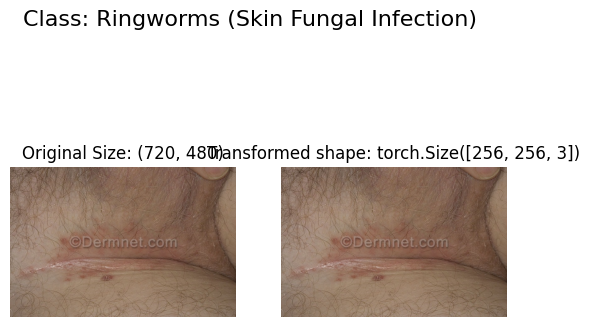

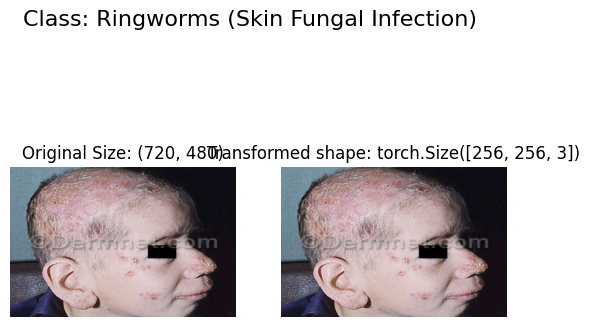

In [14]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=4,
                        seed=42)

Creating the datasets of train and test folders with ImageFolder

In [15]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, #reducing all the images to (64x64)
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [16]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 4208
     Root location: /content/drive/MyDrive/Medical_Dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                Lambda()
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 787
     Root location: /content/drive/MyDrive/Medical_Dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                Lambda()
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
class_names = train_data.classes
class_names

['Acne (Normal to Mild)',
 'Conjunctivitis',
 'Folliculitis',
 'Hives Urticaria',
 'Nail Fungus and Cracked Nails',
 'Ringworms (Skin Fungal Infection)',
 'Stye (Inflammation around eyes)',
 'Warts']

In [18]:
#Mapping the class names to integers for the model training
class_int = train_data.class_to_idx
class_int

{'Acne (Normal to Mild)': 0,
 'Conjunctivitis': 1,
 'Folliculitis': 2,
 'Hives Urticaria': 3,
 'Nail Fungus and Cracked Nails': 4,
 'Ringworms (Skin Fungal Infection)': 5,
 'Stye (Inflammation around eyes)': 6,
 'Warts': 7}

In [19]:
#Verifying the dataset conversion with an example
img, label = train_data[2000][0], train_data[2000][1] # the first number represents the image__number in the train data, and 2nd number represents either tensor or label
print(f"image tensor:\n {img}")
print(f"image shape: {img.shape}")
print(f"image label: {label}")
print(f"label name: {class_names[label]}")

image tensor:
 tensor([[[0.6431, 0.6157, 0.6118,  ..., 0.5451, 0.5412, 0.5373],
         [0.6275, 0.6196, 0.6235,  ..., 0.5569, 0.5490, 0.5490],
         [0.6196, 0.6157, 0.6314,  ..., 0.5529, 0.5529, 0.5490],
         ...,
         [0.7098, 0.7059, 0.7216,  ..., 0.0510, 0.0510, 0.0510],
         [0.7255, 0.7373, 0.7137,  ..., 0.0510, 0.0510, 0.0510],
         [0.7255, 0.7333, 0.7059,  ..., 0.0510, 0.0510, 0.0510]],

        [[0.5373, 0.5059, 0.5020,  ..., 0.4471, 0.4431, 0.4431],
         [0.5255, 0.5098, 0.5098,  ..., 0.4588, 0.4549, 0.4510],
         [0.5137, 0.5059, 0.5176,  ..., 0.4588, 0.4588, 0.4549],
         ...,
         [0.6196, 0.6157, 0.6235,  ..., 0.0510, 0.0510, 0.0510],
         [0.6314, 0.6431, 0.6157,  ..., 0.0471, 0.0510, 0.0510],
         [0.6314, 0.6392, 0.6078,  ..., 0.0471, 0.0510, 0.0392]],

        [[0.5059, 0.4784, 0.4784,  ..., 0.3294, 0.3216, 0.3176],
         [0.4902, 0.4863, 0.4863,  ..., 0.3373, 0.3333, 0.3294],
         [0.4784, 0.4784, 0.4902,  ..., 0.3

Rearranging the Image Dimesions to [H,W,C] from [C,H,W]

image (permuted) size/shape: torch.Size([256, 256, 3])


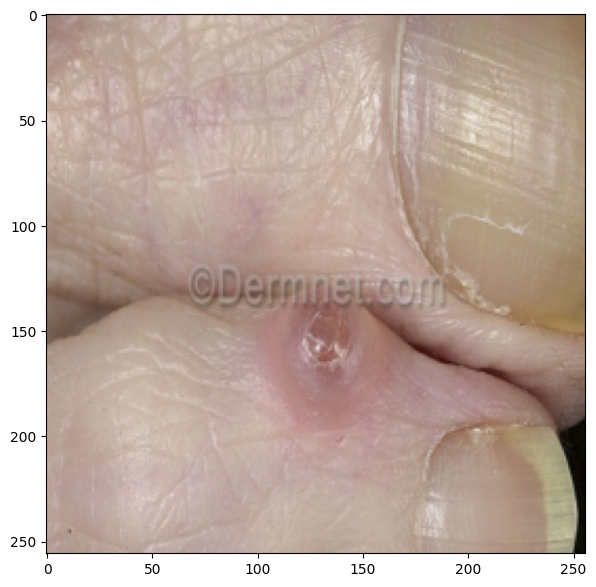

In [20]:
img_permute = img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
print(f"image (permuted) size/shape: {img_permute.shape}")

# The image size is 256x256

For an effective training of the model, dataloader will be used to train the model batch by batch

In [21]:
from torch.utils.data import DataLoader

In [22]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79a8ada417d0>,
 <torch.utils.data.dataloader.DataLoader at 0x79a8af97d010>)

In [23]:
len(train_dataloader), len(test_dataloader), len(train_data), len(test_data) #it is because batch_size we have given is 32 and 4208/32 = 32

(132, 25, 4208, 787)

In [24]:
img, label = next(iter(train_dataloader))
print(f"shape of image: {img.shape}")
print(f"label shape: {label.shape}")

shape of image: torch.Size([32, 3, 256, 256])
label shape: torch.Size([32])


Data Augmentation

In [25]:
import shutil
target_dir = "/content/drive/MyDrive/Medical_Dataset/train_augmented"

In [26]:
classes_to_augment = class_int
classes_to_augment

{'Acne (Normal to Mild)': 0,
 'Conjunctivitis': 1,
 'Folliculitis': 2,
 'Hives Urticaria': 3,
 'Nail Fungus and Cracked Nails': 4,
 'Ringworms (Skin Fungal Infection)': 5,
 'Stye (Inflammation around eyes)': 6,
 'Warts': 7}

In [28]:
augment_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

for class_name, num_images in classes_to_augment.items():
  class_path = os.path.join(train_dir, class_name)
  target_path = os.path.join(target_dir, class_name)
  os.makedirs(target_path, exist_ok=True)

  images = os.listdir(class_path)
  image_count = len(images)

  #Copying the existing images first
  for img in images:
    shutil.copy(os.path.join(class_path, img), os.path.join(target_path, img))

  #Generating Augmented images
  for i in range(1500-image_count):
    img_name = random.choice(images) #selecting a random image
    img_path = os.path.join(class_path, img_name)

    # Load and apply augmentation
    image = Image.open(img_path).convert("RGB")
    augmented_image = augment_pipeline(image)

    # Save augmented image
    aug_img_name = f"aug_{i}_{img_name}"
    augmented_image.save(os.path.join(target_path, aug_img_name))

print("Data augmentation completed for undersampled classes.")

Data augmentation completed for undersampled classes.


THE ABOVE CELL TOOK A LONG TIME TO GET EXECUTE, SO AGAIN FROM HERE, IMPORTING THE LIBRARIES FOR FURTHER PREPROCESSING AFTER THE DATA AUGMENTATION

In [29]:
from google.colab import drive

In [30]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import torch
import torchvision
import numpy as np
import pandas as pd
import PIL
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [32]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [33]:
augmented_images_paths = Path("/content/drive/MyDrive/Medical_Dataset")
augmented_train_dir = Path("/content/drive/MyDrive/Medical_Dataset/train_augmented") #using Path funtion to get paths from drive in PosixPath format
test_dir = Path("/content/drive/MyDrive/Medical_Dataset/test")

augmented_images_paths, augmented_train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Medical_Dataset'),
 PosixPath('/content/drive/MyDrive/Medical_Dataset/train_augmented'),
 PosixPath('/content/drive/MyDrive/Medical_Dataset/test'))

After the augmentation, now each class has around 1500 images of the diseases